# Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA

from chemprop import data, featurizers, models

# Change model input here

In [2]:
checkpoint_path = 'tests/data/example_model_v2.ckpt'  # path to the checkpoint file.
# If the checkpoint file is generated using the training notebook,
# it will be in the `checkpoints` folder with name similar to `checkpoints/epoch=19-step=180.ckpt`.

## Load model

In [3]:
mpnn = models.MPNN.load_from_checkpoint(checkpoint_path)
mpnn

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=147, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=433, out_features=300, bias=True)
    (dropout): Dropout(p=0, inplace=False)
    (tau): ReLU()
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=300, out_features=1, bias=True)
    )
  )
)

# Change data input here

In [4]:
test_path = 'tests/data/smis.csv'
smiles_column = 'smiles'

## Load data

In [5]:
df_test = pd.read_csv(test_path)

smis = df_test[smiles_column]

test_data = [data.MoleculeDatapoint.from_smi(smi) for smi in smis]
test_data[:5]

[MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x295f1c350>, y=None, weight=1, gt_mask=None, lt_mask=None, x_f=None, x_phase=None, V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x295f1c3c0>, y=None, weight=1, gt_mask=None, lt_mask=None, x_f=None, x_phase=None, V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x295f1c4a0>, y=None, weight=1, gt_mask=None, lt_mask=None, x_f=None, x_phase=None, V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x295f1c580>, y=None, weight=1, gt_mask=None, lt_mask=None, x_f=None, x_phase=None, V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x295f1c660>, y=None, weight=1, gt_mask=None, lt_mask=None, x_f=None, x_phase=None, V_f=None, E_f=None, V_d=None)]

# Get featurizer

In [6]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

# Get datasets

In [7]:
test_dset = data.MoleculeDataset(test_data, featurizer=featurizer)
test_loader = data.MolGraphDataLoader(test_dset, shuffle=False)

# Calculate fingerprints

`models.MPNN.fingerprint(inputs : BatchMolGraph)` returns the learned fingerprints of a chemprop model given a batch of input molecules.

In [8]:
fingerprints = torch.Tensor()
for batch in test_loader:
    fingerprints = torch.cat((fingerprints, mpnn.fingerprint(batch.bmg)), 0)
    
fingerprints.shape

torch.Size([100, 300])

# Using fingerprints

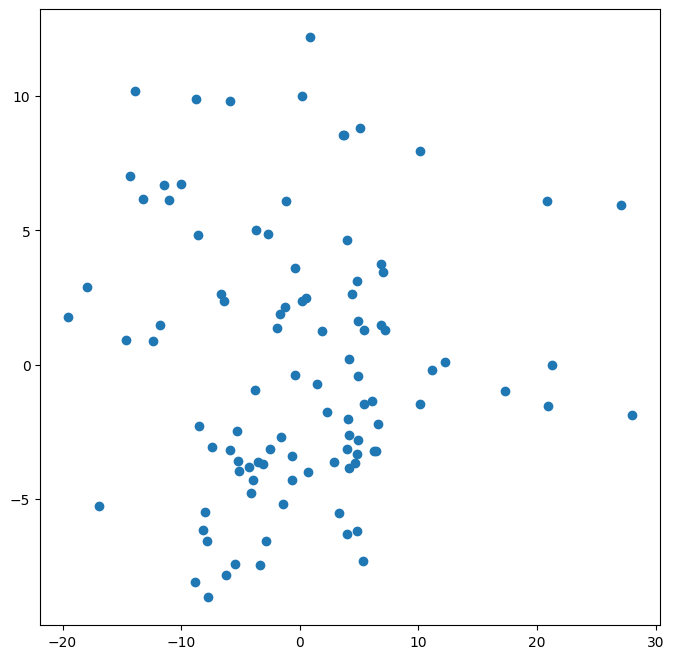

In [9]:
fingerprints = fingerprints.detach()

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(fingerprints)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(principalComponents[:, 0], principalComponents[:, 1])
plt.show()